<a href="https://colab.research.google.com/github/SergeyShchus/OSM/blob/main/Notebook/OSMX_3_Routing%2C_speed_imputation%2C_and_travel_times.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install osmnx

In [2]:
import numpy as np
import osmnx as ox

%matplotlib inline
np.random.seed(0)
ox.__version__

'1.1.2'

In [3]:
place = "Piedmont, California, USA"
G = ox.graph_from_place(place, network_type="drive")
Gp = ox.project_graph(G)

# Пошук найближчого вузла
Функції nearest_nodes і nearest_edges беруть масиви координат x і y (або lng/lat) і повертають кожному найближчий вузол/ребро.


In [4]:
# randomly sample n points spatially-constrained to the network's geometry
points = ox.utils_geo.sample_points(ox.get_undirected(Gp), n=100)
X = points.x.values
Y = points.y.values
X0 = X.mean()
Y0 = Y.mean()

In [5]:
# find each nearest node to several points, and optionally return distance
nodes, dists = ox.nearest_nodes(Gp, X, Y, return_dist=True)

In [6]:
# or, find the nearest node to a single point
node = ox.nearest_nodes(Gp, X0, Y0)
node

53021743

In [7]:
# find each nearest edge to several points, and optionally return distance
edges, dists = ox.nearest_edges(Gp, X, Y, return_dist=True)

In [8]:
# find the nearest edge to a single point
edge = ox.nearest_edges(Gp, X0, Y0)
edge

(53021743, 53021743, 0)

# Основна маршрутизація за відстанню
Виберіть два вузли. Потім знайдіть найкоротший шлях між відправленням і пунктом призначення, використовуючи weight='length', щоб знайти найкоротший шлях, мінімізуючи пройдену відстань (інакше кожне ребро розглядається як вага=1).

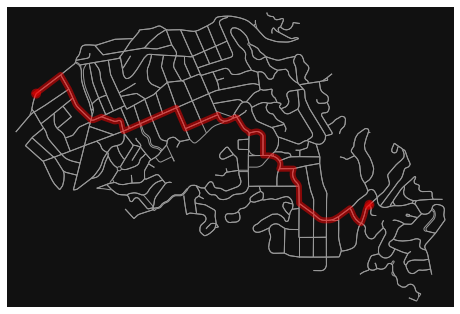

In [14]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G)[0]
dest = list(G)[120]
route = ox.shortest_path(G, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(G, route, route_color="r", route_linewidth=6, node_size=0)

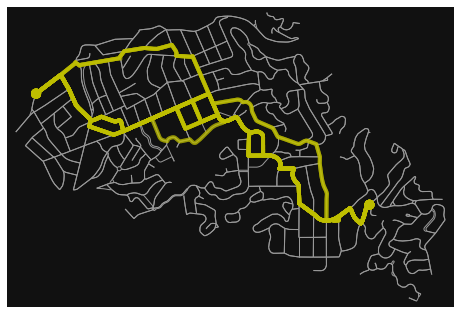

In [16]:
#Або отримати k найкоротших шляхів, зважених якимось атрибутом:
routes = ox.k_shortest_paths(G, orig, dest, k=30, weight="length")
fig, ax = ox.plot_graph_routes(G, list(routes), route_colors="y", route_linewidth=6, node_size=0)

# Розрахунок швидкості та часу руху

In [17]:
#The add_edge_speeds function add edge speeds (km per hour) to graph as new speed_kph edge attributes. 
#Imputes free-flow travel speeds for all edges based on mean maxspeed value of edges, per highway type. 
#This mean-imputation can obviously be imprecise, and the caller can override it by passing in hwy_speeds 
#and/or fallback arguments that correspond to local speed limit standards. See docstring for details.

# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [18]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
residential,124.9,24.1,18.7
secondary,117.3,44.3,9.7
tertiary,106.7,40.2,9.6
tertiary_link,74.7,36.2,7.4
unclassified,28.8,36.2,2.9


In [19]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [20]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G)[1]
dest = list(G)[120]
route1 = ox.shortest_path(G, orig, dest, weight="length")
route2 = ox.shortest_path(G, orig, dest, weight="travel_time")

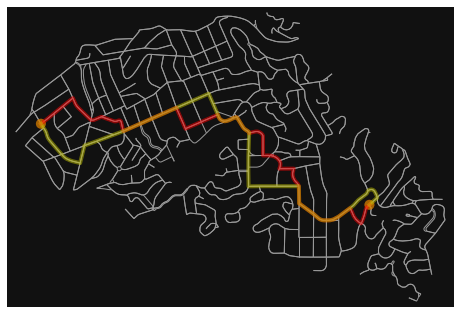

In [23]:
# plot the routes
fig, ax = ox.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

In [24]:
# compare the two routes
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "length")))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "travel_time")))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "travel_time")))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

Route 1 is 3624 meters and takes 322 seconds.
Route 2 is 3804 meters and takes 251 seconds.


## Multiprocessing

In [25]:
# calculate 100,000 shortest-path routes using random origin-destination pairs
n = 100000
origs = np.random.choice(G.nodes, size=n, replace=True)
dests = np.random.choice(G.nodes, size=n, replace=True)

In [26]:
%%time
# it takes 3.2 seconds to solve all the routes using all the cores on my computer
# I have a 24-thread AMD 5900x: performance will depend on your specific CPU
routes = ox.shortest_path(G, origs, dests, weight="travel_time", cpus=None)

CPU times: user 2.18 s, sys: 231 ms, total: 2.41 s
Wall time: 1min 10s


In [27]:
%%time
# it takes 43 seconds to solve all the routes using just 1 core on my computer
routes = ox.shortest_path(G, origs, dests, weight="travel_time", cpus=1)

CPU times: user 1min 7s, sys: 90.2 ms, total: 1min 7s
Wall time: 1min 8s


In [28]:
# how many total results did we get
print(len(routes))

# and how many were solvable paths
# some will be unsolvable due to directed graph perimeter effects
routes_valid = [r for r in routes if r is not None]
print(len(routes_valid))

100000
99109


# Різні маршрутні примітки
Маршрут правильно обробляє вулиці з одностороннім рухом:

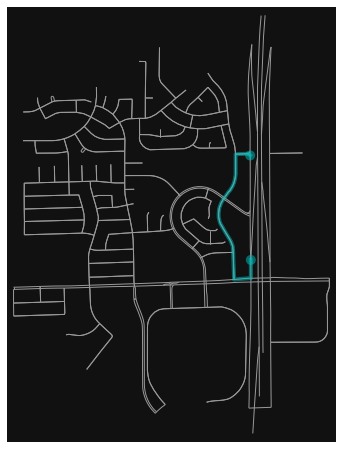

In [29]:
G2 = ox.graph_from_address(
    "N. Sicily Pl., Chandler, Arizona",
    dist=800,
    network_type="drive",
    truncate_by_edge=True,
)
origin = (33.307792, -111.894940)
destination = (33.312994, -111.894998)
origin_node = ox.distance.nearest_nodes(G2, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(G2, destination[1], destination[0])
route = ox.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G2, route, route_color="c", node_size=0)

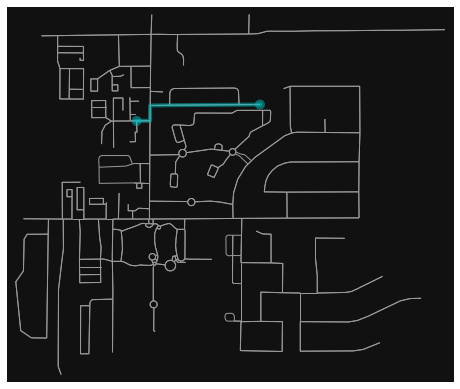

In [32]:
#when there are parallel edges between nodes in the route, OSMnx picks the shortest edge to plot:

location_point = (33.299896, -111.831638)
G2 = ox.graph_from_point(location_point, dist=400, truncate_by_edge=True)
origin = (33.301821, -111.829871)
destination = (33.301402, -111.833108)
origin_node = ox.distance.nearest_nodes(G2, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(G2, destination[1], destination[0])
route = ox.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G2, route, route_color="c", node_size=0)